In [37]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T
from pyspark.sql.types import DoubleType, FloatType
from pyspark.sql.functions import col, mean, stddev, corr, isnan, when, floor
import traceback
import pandas as pd
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.plot_heatmap import plot_corr_heatmap

### 1. Load the feature dataset for transformation and modeling.
Load the table `default.flights_2006_features` from the Hive metastore. If that fails, it falls back to reading the Parquet files directly from HDFS via the `out_path`.

In [5]:
# Ensure spark session (re-use kernel session when available)
try:
    spark
except NameError:
    spark = SparkSession.builder.enableHiveSupport().getOrCreate()

# HDFS path fallback (same as Notebook 04)
out_path = 'hdfs://namenode:8020/data/parquet/flights_2006_features'

# Try metastore table first, else fallback to parquet path
try:
    print('Trying to load from metastore table default.flights_2006_features')
    features_df = spark.table('default.flights_2006_features')
    print('Loaded from metastore table')
except Exception as e:
    print('Metastore load failed:', e)
    print('Falling back to reading Parquet from', out_path)
    features_df = spark.read.option('mergeSchema','true').parquet(out_path)
    print('Loaded from Parquet path')

Trying to load from metastore table default.flights_2006_features
Metastore load failed: "Table or view not found: `default`.`flights_2006_features`;;\n'UnresolvedRelation `default`.`flights_2006_features`\n"
Falling back to reading Parquet from hdfs://namenode:8020/data/parquet/flights_2006_features
Loaded from Parquet path


In [9]:
# Quick checks: count, schema, sample
print('rows:', features_df.count())
features_df.printSchema()
features_df.show(5, truncate=False)

# Small missingness summary (pandas)
total = features_df.count()
miss = []
for c in features_df.columns:
    col_expr = F.col(c)
    try:
        nnull = features_df.filter(col_expr.isNull() | F.isnan(col_expr) | (col_expr == '')).count()
    except Exception:
        nnull = features_df.filter(col_expr.isNull() | (col_expr == '')).count()
    miss.append((c, int(nnull), round(nnull / total * 100, 3)))

import pandas as pd
miss_df = pd.DataFrame(miss, columns=['column', 'n_missing', 'pct_missing']).sort_values('pct_missing', ascending=False)
print(miss_df)

rows: 7003802
root
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)

+----------+---------+-------+----------+-------+----------+--------+--------+---------+------+-------+--------+----+-----+
|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|DepDelay|Distance|Cancelled|TaxiIn|TaxiOut|ArrDelay|Year|Month|
+----------+---------+-------+----------+-------+----------+--------+--------+---------+------+-------+--------+----+-----+
|3         |1        |1608   |1610      |17

## 2. Data Transformation

### 2.1 DepHour/ArrHour:
`time-of-day` is a strong predictor of delays (rush hours, night operations). Extracting hour (or better, minutes-of-day / cyclical encoding) exposes this signal to models.

In [20]:
def hhmm_to_hour(col_expr):
    # if stored as int like 745, dividing by 100 gives hour; handle nulls
    return when(col_expr.isNull(), None).otherwise((col_expr / 100).cast('int'))

df_trans = features_df
# create DepHour and ArrHour if times exist
if 'DepTime' in df_trans.columns:
    df_trans = df_trans.withColumn('DepHour', hhmm_to_hour(F.col('DepTime')))
if 'ArrTime' in df_trans.columns:
    df_trans = df_trans.withColumn('ArrHour', hhmm_to_hour(F.col('ArrTime')))

### 2.2 Handle missing values: Mean imputation using Spark ML Imputer

In [21]:
# numeric columns to impute/cast/scale 
numeric_candidates = ['ArrTime','DepDelay','DepTime','ArrDelay','Distance','TaxiIn','TaxiOut']
numeric_cols = [c for c in numeric_candidates if c in df_trans.columns]
print('Numeric columns found for processing:', numeric_cols)

Numeric columns found for processing: ['ArrTime', 'DepDelay', 'DepTime', 'ArrDelay', 'Distance', 'TaxiIn', 'TaxiOut']


In [23]:
# Cast to DoubleType to ensure Imputer accepts the columns (Imputer requires float/double)
for c in numeric_cols:
    df_trans = df_trans.withColumn(c, F.col(c).cast(DoubleType()))

In [24]:
# Mean imputation using Spark ML Imputer
if numeric_cols:
    imputer = Imputer(inputCols=numeric_cols, outputCols=[f'{c}_imp' for c in numeric_cols]).setStrategy('mean')
    df_imp = imputer.fit(df_trans).transform(df_trans)
    # rename imputed cols back to original names
    for c in numeric_cols:
        df_imp = df_imp.drop(c).withColumnRenamed(f'{c}_imp', c)
else:
    df_imp = df_trans

### 2.3 Scaling: 
The numeric columns were standardized with `StandardScaler` so that all features are on the same scale. This helps the model treat each variable fairly and avoids bias from differing value ranges.

In [25]:
feature_cols = list(numeric_cols)
# include DepHour/ArrHour if they were created earlier
for tcol in ('DepHour','ArrHour'):
    if tcol in df_imp.columns and tcol not in feature_cols:
        feature_cols.append(tcol)

if feature_cols:
    print('Assembling and scaling feature columns:', feature_cols)
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='features_vec')
    df_vec = assembler.transform(df_imp)
    scaler = StandardScaler(inputCol='features_vec', outputCol='scaled_features', withMean=True, withStd=True)
    scaler_model = scaler.fit(df_vec)
    df_scaled = scaler_model.transform(df_vec)
    print('Scaled vector sample:')
    df_scaled.select('features_vec','scaled_features').show(5, truncate=False)
else:
    print('No numeric features found to assemble/scale; skipping scaling step')
    df_scaled = df_imp

# expose df_scaled for downstream cells
df_transformed = df_scaled
print('Transformation complete. Rows:', df_transformed.count())

Assembling and scaling feature columns: ['ArrTime', 'DepDelay', 'DepTime', 'ArrDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'DepHour', 'ArrHour']
Scaled vector sample:
+----------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features_vec                                        |scaled_features                                                                                                                                                                          |
+----------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[1724.0,-2.0,1608.0,4.0,196.0,7.0,15.0,16.0,17.0]   |[0.47339783445560407,-0.36091221115300626,0.561731813652075

## 3. Display transformed schema:

In [26]:
# show transformed schema/sample
print('Transformed schema:')
df_trans.printSchema()
print('Sample rows after simple transformations:')
df_trans.select(*[c for c in df_trans.columns if c in ['Year','Month','DepTime','DepHour','ArrTime','ArrHour','ArrDelay','late']]).show(5, truncate=False)

Transformed schema:
root
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DepHour: integer (nullable = true)
 |-- ArrHour: integer (nullable = true)

Sample rows after simple transformations:
+-------+-------+--------+----+-----+-------+-------+
|DepTime|ArrTime|ArrDelay|Year|Month|DepHour|ArrHour|
+-------+-------+--------+----+-----+-------+-------+
|1608.0 |1724.0 |4.0     |2006|7    |16     |17     |
|1917.0 |2215.0 |0.0     |2006|7    |19     |22     |
|1314.0 |1553.0 |-1

## 4. Save transformed parquet file and register as a Hive table

In [28]:
# Optionally persist transformed data and register as a table for downstream notebooks
out_trans_path = 'hdfs://namenode:8020/data/parquet/flights_2006_transformed'
try:
    df_trans.repartition(8).write.mode('overwrite').partitionBy('Year','Month').option('compression','snappy').parquet(out_trans_path)
    print('Wrote transformed data to', out_trans_path)
    try:
        spark.sql(f"CREATE TABLE IF NOT EXISTS default.flights_2006_transformed USING PARQUET OPTIONS (path '{out_trans_path}')")
        print('Registered default.flights_2006_transformed')
    except Exception as e_reg:
        print('Warning: failed to register transformed table:', e_reg)
        print('You can still read the Parquet directly in other notebooks with spark.read.parquet(out_trans_path)')
except Exception as e:
    print('Failed to write transformed data:', e)
    raise

Wrote transformed data to hdfs://namenode:8020/data/parquet/flights_2006_transformed
Registered default.flights_2006_transformed


## 5. Distribution Analysis
Top 3 features: 
- `ArrDelay` is the target (we want its distribution). 
- `DepDelay` is a strong predictor of arrival delays. 
- `Distance` correlates with flight duration and can influence delay patterns.

Selected columns found: ['ArrDelay', 'DepDelay', 'Distance']
Plotting sample size: 140618


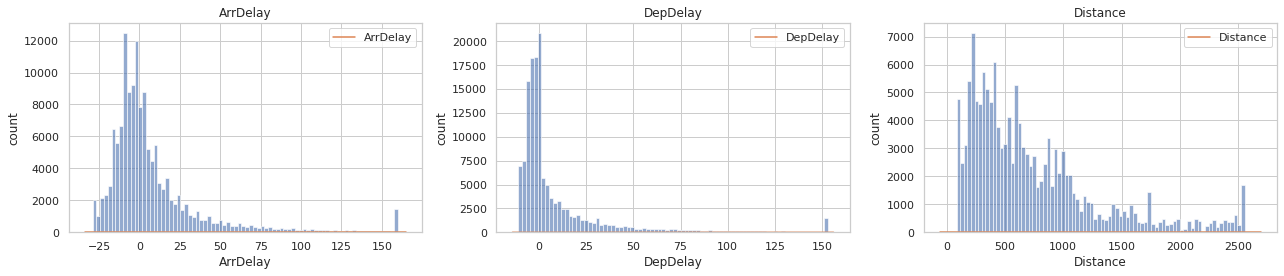


Summary stats (sample):


,ArrDelay,DepDelay,Distance
count,140618.000000,140618.000000,140618.000000
mean,8.725469,10.036688,733.340248
std,36.092245,32.878696,576.981095
min,-73.000000,-1037.000000,31.000000
25%,-9.000000,-4.000000,318.000000
50%,-1.000000,0.000000,577.000000
75%,13.000000,10.000000,964.000000
max,1280.000000,1283.000000,4962.000000


In [34]:
# Plot distributions for ArrDelay, DepDelay, Distance (sampling for plotting)
cols = ['ArrDelay','DepDelay','Distance']
sel_cols = [c for c in cols if c in df_transformed.columns]
if not sel_cols:
    print('None of the selected columns present in df_transformed:', cols)
else:
    print('Selected columns found:', sel_cols)
    # Try a light sample; fallback to limit if sample yields too few rows
    try:
        pdf = df_transformed.select(sel_cols).na.drop().sample(False, 0.02, seed=42).toPandas()
    except Exception:
        pdf = df_transformed.select(sel_cols).na.drop().limit(100000).toPandas()
    if len(pdf) < 2000:
        # if sample too small, try a larger limit-based sample
        pdf = df_transformed.select(sel_cols).na.drop().limit(100000).toPandas()
    print('Plotting sample size:', len(pdf))

    sns.set(style='whitegrid')
    # create exactly 3 side-by-side axes so plots appear on the same row
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    # if fewer than 3 selected cols, we'll plot into the first N axes and hide the rest
    for i, c in enumerate(sel_cols[:3]):
        ax = axes[i]
        lo, hi = pdf[c].quantile(0.01), pdf[c].quantile(0.99)
        series = pdf[c].clip(lower=lo, upper=hi).dropna()
        # matplotlib histogram + seaborn kde overlay (compatible with older seaborn)
        ax.hist(series, bins=80, color='C0', alpha=0.6)
        try:
            sns.kdeplot(series, ax=ax, color='C1')
        except Exception:
            # if seaborn KDE fails, ignore and keep the histogram
            pass
        ax.set_title(c)
        ax.set_xlabel(c)
        ax.set_ylabel('count')
    # hide any unused axes
    for j in range(len(sel_cols), 3):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

    print('\nSummary stats (sample):')
    display(pdf[sel_cols].describe())


## 6. Correlation Matrix

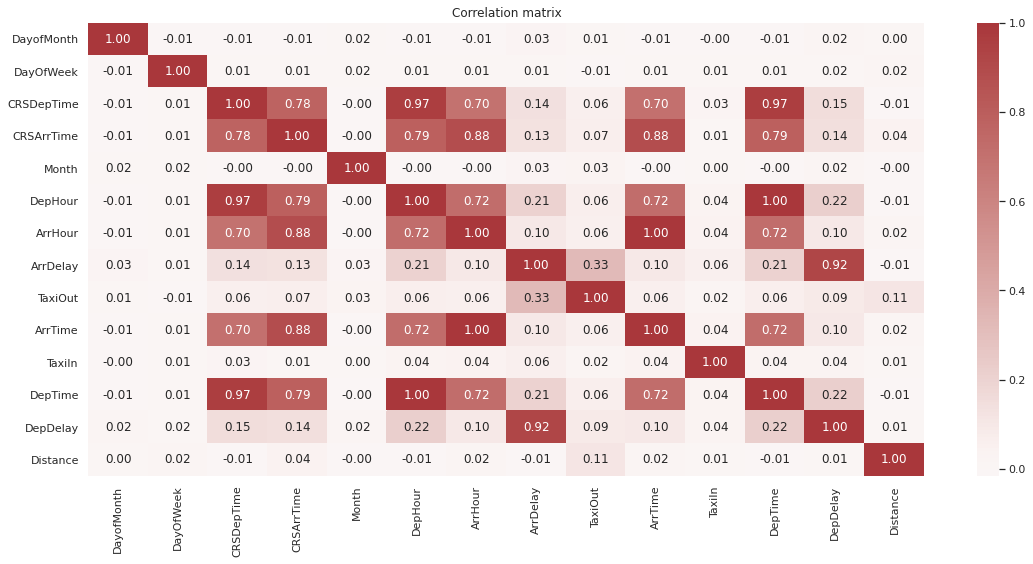

In [41]:
df_corr = df_transformed.drop('Year', 'Cancelled')
# import from scripts
corr = plot_corr_heatmap(df_corr, sample_fraction=0.02, max_rows=50000, figsize=(16,8))

#### Interesting Findings:
1. **Departure and Arrival Delays are strongly linked to departure times**

`DepDelay` has a very high correlation with `ArrDelay` (~0.91), which is expected — if a flight departs late, it is very likely to arrive late.

`CRSDepTime` and `DepTime` also show moderate positive correlation with `ArrDelay` (~0.13–0.20), suggesting that flights scheduled during certain hours are more prone to delays, likely due to peak traffic periods.

2. **Flight distance has almost no effect on arrival delay**

`Distance` has a near-zero correlation with `ArrDelay` (~-0.006), indicating that external factors such as congestion, weather, and operational efficiency matter far more than the length of the flight.

3. **Taxi times modestly affect arrival delay**

`TaxiOut` correlates with `ArrDelay` (~0.34) more than `TaxiIn` (~0.07). This makes sense because delays during departure (pushback, taxiing) accumulate and contribute more to overall arrival delays than delays after landing.

4. **Scheduled times are highly interrelated**

`CRSDepTime`, `DepTime`, `CRSArrTime`, `ArrTime`, `DepHour`, and `ArrHour` all show very high correlations with each other (0.70–0.99). This suggests that scheduled times are tightly linked and capture similar temporal patterns, so some of these features might be redundant in a predictive model.